***

### **Importante** 


- **Realice varios comentarios haciendo uso de una etiqueta html para darle color al comentario. Sin embargo, al subir mis notebooks a GITHUB las secciones donde realice los comentarios a color aparecen en blanco.**  

- **El "Enable Scrolling for Outputs" no se respeta al subir este contenido a GITHUB, por lo tanto, la impresión de los datos puede ser larga.**  

**Lo anterior no afecta en absoluto el contenido principal y el funcionamiento del documento, por lo que, si lo deseas, lo puedes ejecutar sin ningún problema en tu ordenador.**

***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Cargamos nuestros datos:

In [2]:
from mnist import MNIST

In [3]:
Datos_MNIST = MNIST("MNIST_dataset") # Cargamos la totalidad de datos de MNIST.

In [4]:
imagenes_entrenamiento, etiquetas_entrenamiento = Datos_MNIST.load_training() # Cargando datos de entrenamiento.
imagenes_testeo, etiquetas_testeo = Datos_MNIST.load_testing() # Cargando datos para probar nuestra red una vez se halla entrenado.

Damos formato a nuestros datos MNIST:

In [5]:
imagenes_entrenamiento, etiquetas_entrenamiento = np.asarray(imagenes_entrenamiento), np.asarray(etiquetas_entrenamiento)
imagenes_testeo, etiquetas_testeo = np.asarray(imagenes_testeo), np.asarray(etiquetas_testeo)

In [6]:
imagenes_entrenamiento = (imagenes_entrenamiento/imagenes_entrenamiento.max()).astype("float64")

In [7]:
imagenes_testeo = (imagenes_testeo/imagenes_testeo.max()).astype("float64")

In [8]:
def one_hot_encode (etiquetas):
    """Esta función nos arroja un vector one_hot para cada etiqueta."""
    
    cantidad_clases = len(set(etiquetas))
    vector_OneHot = np.zeros(shape=(etiquetas.shape[0], cantidad_clases), dtype="float64")
    
    for i in range(vector_OneHot.shape[0]):
        vector_OneHot[i,etiquetas[i]] = 1
        
    return vector_OneHot

In [9]:
etiquetas_entrenamiento_ONE_HOT = one_hot_encode(etiquetas_entrenamiento)
etiquetas_testeo_ONE_HOT = one_hot_encode(etiquetas_testeo)

Tomaremos 1,000 muestras del conjunto de entrenamiento para entrenar de maner rápida a nuestra red:

In [10]:
muestras_entrenamiento_500 = imagenes_entrenamiento[:500]
etiquetas_entrenamiento_500 = etiquetas_entrenamiento_ONE_HOT[:500]

In [11]:
print(muestras_entrenamiento_500.shape)
print(etiquetas_entrenamiento_500.shape)

(500, 784)
(500, 10)


Tomaremos 180 muestras para el conjunto de validación:

In [12]:
validacion_img_aleatorias = imagenes_entrenamiento[500:]
validacion_etiquetas_aleatorias = one_hot_encode(etiquetas_entrenamiento[500:])

print(validacion_img_aleatorias.shape)
print(validacion_etiquetas_aleatorias.shape)

(59500, 784)
(59500, 10)


In [13]:
validacion_etiquetas_aleatorias[:10]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

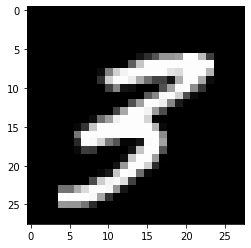

In [14]:
plt.imshow(validacion_img_aleatorias[9].reshape(28,28), cmap="gray")

Recordemos que (para nuestro caso), las representaciones digitales de los números ya se encuentran en 1D. Las dimensiones para nuestras muestras de entrenamiento son: (lote, numeros).

*Comienza nuestro algoritmo de aprendizaje:*

In [18]:
import random

def generador (x):
    """Esta función es un generador y nos ayuda a ahorrar memoria, dado que va entregando cada número de la secuencia conforme este es
    solicitado, a diferencia de una lista convecional que genera todos los números, los carga en memoria y luego itera sobre estos."""
    
    for i in range(x):
        
        yield i

#################################
relu = lambda sp: (sp > 0) * sp
derivada_relu = lambda sp: sp > 0
#################################

def algoritmo_aprendizaje (entradas, salidas_deseadas, pesos, alfa, epocas, datos_validacion=False):
    """Esta función ejecuta el algoritmo de aprendizaje de nuestra red neuronal."""
    
    pesos_capas = [pesos_x_capa.copy() for pesos_x_capa in pesos]
    
    error_deseado = float(input("\nHola ¿Cuál es el error que mínimo que deseas para la red neuronal?: "))
    regularizacion_ = int(input("¿Qué tipo de regularización deseas?: Ninguno (0) / Dropout(1)"))
    
    if regularizacion_ == 1:
        
        porcentaje_dpt = float(input("¿Qué porcentaje de DROPOUT deseas? 0 < dp < 1\n"))
    
    error_red = list()
    error_validacion = list()
    
    for epoca in generador(epocas):
        
        error_x_entrada, aciertos = 0.0, 0.0
        
        for entrada, salida_deseada in zip(entradas, salidas_deseadas): # entrada = capa_0.
            
            # Propagación hacia adelante. Nuestra red realiza la predicción (o inferencia), por cada muestra:
            
            capa_1 = relu(entrada@pesos_capas[0]).reshape(1,-1) # Forma resultante: Vector.
            
            if regularizacion_ == 1:
                
                assert capa_1.shape[1]%2 == 0, "LA LONGITUD DEL VECTOR DE LA CAPA 1 DEBE SER 'PAR' PARA PODER APLICAR EL PORCENTAJE \
                EXACTO DE 'DROPOUT' DESEADO."
                
                # Vector Dropout:
                unos = (1 - porcentaje_dpt) * capa_1.shape[1]
                ceros = porcentaje_dpt * capa_1.shape[1]
                
                ceros_y_unos = list(np.zeros(shape=(int(ceros)))) + \
                list(np.ones(shape=(int(unos))))
                
                random.shuffle(ceros_y_unos) # Revolvemos los 1's y 0's para exista aleatoriedad.
                
                # Multiplicamos el vector de  la capa 1 por el vector Dropout y compensamos el vector resultante dividiendo entre 
                # el procentaje de Dropout:
                dropout = np.asarray(ceros_y_unos).reshape(1,-1)
                capa_1 *= dropout*(1/porcentaje_dpt)
            
            capa_2 = capa_1@pesos_capas[1] # Forma resultante: Vector. Para este caso, este vector representa las predicciones.
            
            error_x_entrada += np.sum((capa_2 - salida_deseada)**2)
            
            aciertos += int(np.argmax(capa_2) == np.argmax(salida_deseada))
            
            # Backpropagation. Calculamos los delta de cada neurona de la red y sus respectivos pesos delta:
            
            # Deltas y pesos delta de neuronas en la capa 2:
            deltas_neuronas_salida = 2*(capa_2 - salida_deseada)*1
            pesos_delta_ncs =  capa_1.T.dot(deltas_neuronas_salida)
            
            # Deltas y pesos delta de nueronas en la capa 1:
            deltas_neuronas_c1 = derivada_relu(capa_1)*(pesos_capas[1]@deltas_neuronas_salida.T).T
            if regularizacion_ == 1:
                deltas_neuronas_c1 *= dropout # Multiplicamos las deltas de la capa 1 por el vector de dropout.
            pesos_delta_nc1 = entrada.reshape(1,-1).T.dot(deltas_neuronas_c1)
            
            # Actualizamos los parámetros:
            
            # Actualizamos los pesos que se encuentran entre las capas 1 y 2:
            pesos_capas[1] -= alfa * pesos_delta_ncs
            
            # Actualizamos los pesos que se encuentran entre las capas 0 y 1:
            pesos_capas[0] -= alfa * pesos_delta_nc1
            
        if datos_validacion:
            
            # Validamos el aprendizaje de nuestra en cada época:
            error_x_muestra_validacion = 0
            aciertos_validacion = 0

            for numero, etiqueta in zip(datos_validacion[0], datos_validacion[1]): # datos_validacion contienen a los números y etiquetas.

                c1 = relu(numero@pesos_capas[0]).reshape(1,-1)
                c2 = c1@pesos_capas[1]

                error_x_muestra_validacion += np.sum((c2 - etiqueta)**2)
                aciertos_validacion += int(np.argmax(c2) == np.argmax(etiqueta))

            error_total_validacion = (error_x_muestra_validacion/len(datos_validacion[1]))*100 # ECM dado en porcentaje en D. Validación.
            error_validacion.append(error_total_validacion)
            
        # Datos generales de la red:
        error_x_epoca = (error_x_entrada/len(entradas))*100 # ECM dado en porcentaje en D. Entrenamiento.
        error_red.append(error_x_epoca)
        
        print(f"\nÉpoca: {epoca+1}")
        print(f"Error Total de la Red sobre los Datos de Entrenamiento: {np.around(error_x_epoca,10)}%")
        print(f"Aciertos sobre Datos de Entrenamiento: {aciertos}")
        
        if datos_validacion:
            
            print(f"Error de Validación: {np.around(error_total_validacion,10)}%")
            print(f"Aciertos sobre los Datos de Validación: {aciertos_validacion}\n")
        
        if error_x_epoca <= error_deseado:
            print("\nEl error de la red neuronal es menor o igual al error deseado.\n")
            break
        
    return pesos_capas, error_red, error_validacion

### <font color="darkorange">Porcentaje DROPOUT = 0.5 (Deep learning with python, pág 109).</font>

Las capas a las cuales les son aplicadas la regularización **dropout** son las *ocultas*. Regularmente se fija el **dropout** a 50% (para las neuronas de la capas ocultas), o 20%(para las neuronas de entrada). Sin embargo, nosotros **no** aplicaremos **dropout** a las neuronas de entrada. Por otro lado, hemos fijado el **dropout** al 50% (0.5) para las neuronas de la capa oculta, es decir, la mitad del total de las neuronas de la capa que cuenta con esta regularización se apagarán de manera aleatoria. Esto significa que debemos reescalar el valor de nuestra capa a la cual le fue aplicado **dropout**, debido a que necesitamos compensar los valores del vector de salida de la capa con **dropout**. Esto se realiza dividiendo al vector de la capa con **dropout** por el *Porcentaje de Dropout*, o expresado de otra manera, multiplicando esta capa con **dropout** por $1/PorcentajeDropout$; para nuestro caso la fórmula queda como $1/0.5 = 2$. Es por esta razón que hemos multiplicado por $2$ a la capa con **dropout**. Asimismo, para el caso de la **backpropagation** debemos de tomar en cuenta al vector de dropout, multiplicando a las deltas de la capa con **dropout** por este vector. Lo anterior, debido a que las neuronas afectadas por el vector **dropout** no aportaron nada durante la **forwardpropagation**.

Creamos una función que nos permita realizar predicciones:

In [16]:
def predicciones (pesos,entradas):
    
    vector_prediccion = list()
    
    for entrada in entradas:
        neuronas_capa_1 = relu(entrada.dot(pesos[0])) # Forma resultante: Vector.
        neuronas_de_salida = neuronas_capa_1@pesos[1] # Forma resultante: Vector.
        vector_prediccion.append(np.argmax(neuronas_de_salida))
            
    return np.asarray(vector_prediccion)

Definimos los datos a ingresar a la red:

In [17]:
np.random.seed(1)
alfa, iteraciones, neuronas_capa_oculta, pixeles_por_imagen, numero_de_clases = (0.005, 350, 40, 784, 10)

pesos_0_1 = 0.2*np.random.random((pixeles_por_imagen, neuronas_capa_oculta)) - 0.1 # Pesos entre capas 0 y 1.
pesos_1_2 = 0.2*np.random.random((neuronas_capa_oculta, numero_de_clases)) - 0.1 # Pesos entre capas 1 y 2.

### **A**

### <font color="red">Entrenamos dos modelos (uno con regularización DROPOUT y otro sin regularización), sobre las primeras 500 muestras del conjunto de entrenamiento:</font>

### Con Regularización Dropout:

Entrenamos nuestra red:

In [19]:
pesos_entrenados, error_red, error_validacion = algoritmo_aprendizaje(muestras_entrenamiento_500, etiquetas_entrenamiento_500, 
                                                                      [pesos_0_1, pesos_1_2], alfa, iteraciones,
                                                                      [validacion_img_aleatorias, validacion_etiquetas_aleatorias])


Hola ¿Cuál es el error que mínimo que deseas para la red neuronal?:  0
¿Qué tipo de regularización deseas?: Ninguno (0) / Dropout(1) 1
¿Qué porcentaje de DROPOUT deseas? 0 < dp < 1
 0.5



Época: 1
Error Total de la Red sobre los Datos de Entrenamiento: 88.8532789814%
Aciertos sobre Datos de Entrenamiento: 150.0
Error de Validación: 72.1457545309%
Aciertos sobre los Datos de Validación: 31353


Época: 2
Error Total de la Red sobre los Datos de Entrenamiento: 69.2608596291%
Aciertos sobre Datos de Entrenamiento: 266.0
Error de Validación: 62.291662175%
Aciertos sobre los Datos de Validación: 37573


Época: 3
Error Total de la Red sobre los Datos de Entrenamiento: 64.2475180775%
Aciertos sobre Datos de Entrenamiento: 277.0
Error de Validación: 56.9947266552%
Aciertos sobre los Datos de Validación: 40332


Época: 4
Error Total de la Red sobre los Datos de Entrenamiento: 59.3465375991%
Aciertos sobre Datos de Entrenamiento: 311.0
Error de Validación: 52.8351742962%
Aciertos sobre los Datos de Validación: 41615


Época: 5
Error Total de la Red sobre los Datos de Entrenamiento: 54.5443114776%
Aciertos sobre Datos de Entrenamiento: 329.0
Error de Validación: 51.9514312156%
Aci

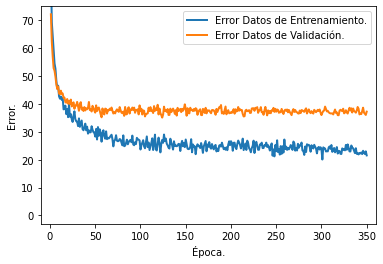

In [32]:
epocas = range(1, len(error_red)+1)
plt.plot(epocas, error_red, lw=2, label="Error Datos de Entrenamiento.")
plt.plot(epocas, error_validacion, lw=2, label="Error Datos de Validación.")
plt.axis([-10,350+10,-3,75])
plt.xlabel("Época.")
plt.ylabel("Error.")
plt.legend()
plt.show()

In [23]:
vector_prediccion_entrenamiento = predicciones(pesos_entrenados, imagenes_entrenamiento[:500])
print(vector_prediccion_entrenamiento.shape,'\n')

precision_datos_entrenamiento = ((etiquetas_entrenamiento[:500] == vector_prediccion_entrenamiento).sum()/len(etiquetas_entrenamiento[:500]))*100
print(f"La precisión sobre los {imagenes_entrenamiento[:500].shape[0]} datos de entrenamiento es del {precision_datos_entrenamiento}%")

(500,) 

La precisión sobre los 500 datos de entrenamiento es del 99.4%


In [24]:
vector_de_prediccion_testeo = predicciones(pesos_entrenados, imagenes_testeo[:])
print(vector_de_prediccion_testeo.shape,'\n')

precision_datos_testeo = ((etiquetas_testeo[:] == vector_de_prediccion_testeo).sum()/len(etiquetas_testeo[:]))*100
print(f"La precisión sobre los {imagenes_testeo[:].shape[0]} datos de prueba es del {precision_datos_testeo}%")

(10000,) 

La precisión sobre los 10000 datos de prueba es del 81.17%


In [25]:
print(f"Cantidad de aciertos en el conjunto de testeo: {(etiquetas_testeo[:] == vector_de_prediccion_testeo).sum()}")

Cantidad de aciertos en el conjunto de testeo: 8117


### Sin Regularización Dropout:

In [26]:
pesos_entrenados_sdt, error_red_sdt, error_validacion_sdt = algoritmo_aprendizaje(muestras_entrenamiento_500, etiquetas_entrenamiento_500, 
                                                                      [pesos_0_1, pesos_1_2], alfa, iteraciones,
                                                                      [validacion_img_aleatorias, validacion_etiquetas_aleatorias])


Hola ¿Cuál es el error que mínimo que deseas para la red neuronal?:  0
¿Qué tipo de regularización deseas?: Ninguno (0) / Dropout(1) 0



Época: 1
Error Total de la Red sobre los Datos de Entrenamiento: 72.0739853851%
Aciertos sobre Datos de Entrenamiento: 258.0
Error de Validación: 60.1819085666%
Aciertos sobre los Datos de Validación: 39138


Época: 2
Error Total de la Red sobre los Datos de Entrenamiento: 45.7590592673%
Aciertos sobre Datos de Entrenamiento: 393.0
Error de Validación: 52.5947381051%
Aciertos sobre los Datos de Validación: 43034


Época: 3
Error Total de la Red sobre los Datos de Entrenamiento: 36.3506141037%
Aciertos sobre Datos de Entrenamiento: 430.0
Error de Validación: 48.4811387365%
Aciertos sobre los Datos de Validación: 45095


Época: 4
Error Total de la Red sobre los Datos de Entrenamiento: 30.2556462742%
Aciertos sobre Datos de Entrenamiento: 450.0
Error de Validación: 45.7211769069%
Aciertos sobre los Datos de Validación: 46250


Época: 5
Error Total de la Red sobre los Datos de Entrenamiento: 25.9499364137%
Aciertos sobre Datos de Entrenamiento: 460.0
Error de Validación: 43.9893478878%
Ac

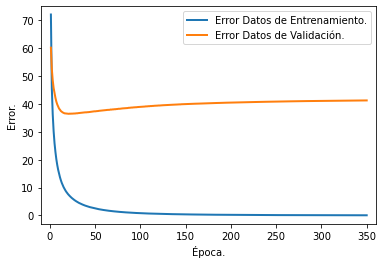

In [31]:
epocas = range(1, len(error_red_sdt)+1)
plt.plot(epocas, error_red_sdt, lw=2, label="Error Datos de Entrenamiento.")
plt.plot(epocas, error_validacion_sdt, lw=2, label="Error Datos de Validación.")
plt.axis([-10,350+10,-3,75])
plt.xlabel("Época.")
plt.ylabel("Error.")
plt.legend()
plt.show()

In [33]:
vector_prediccion_entrenamiento_sdt = predicciones(pesos_entrenados_sdt, imagenes_entrenamiento[:500])
print(vector_prediccion_entrenamiento_sdt.shape,'\n')

precision_datos_entrenamiento_sdt = ((etiquetas_entrenamiento[:500] == vector_prediccion_entrenamiento_sdt).sum()/len(etiquetas_entrenamiento[:500]))*100
print(f"La precisión sobre los {imagenes_entrenamiento[:500].shape[0]} datos de entrenamiento es del {precision_datos_entrenamiento_sdt}%")

(500,) 

La precisión sobre los 500 datos de entrenamiento es del 100.0%


In [34]:
vector_de_prediccion_sdt_testeo = predicciones(pesos_entrenados_sdt, imagenes_testeo[:])
print(vector_de_prediccion_sdt_testeo.shape,'\n')

precision_datos_testeo_sdt_testeo = ((etiquetas_testeo[:] == vector_de_prediccion_sdt_testeo).sum()/len(etiquetas_testeo[:]))*100
print(f"La precisión sobre los {imagenes_testeo[:].shape[0]} datos de prueba es del {precision_datos_testeo_sdt_testeo}%")

(10000,) 

La precisión sobre los 10000 datos de prueba es del 79.67999999999999%


In [35]:
print(f"Cantidad de aciertos en el conjunto de testeo: {(etiquetas_testeo[:] == vector_de_prediccion_sdt_testeo).sum()}")

Cantidad de aciertos en el conjunto de testeo: 7968


**Observaciones:**

Si analizamos ambas gráficas (las gráfica del modelo con dropout y sin dropout), nos daremos cuenta que el *Error Datos de Validación (línea naranja)* es muy similar en ambas gráficas. Sin embargo, se aprecia que el error *Error Datos de Entrenamiento (línea azul)*, es mucho menor en el segundo modelo (modelo sin dropout); esto se debe a que nuestra sin dropout ha memorizado las muestras de entrenamiento, mientras que en el primer modelo prevalecen más las características principales de nuestros datos a identificar que el ruido. Esto se aprecia en la precisión sobre los datos de entrenamiento.

Los errores pertenecientes al primer modelo (modelo con dropout), oscilan debido a que la regularización *dropout* apaga y enciende neuronas de manera aleatoria por cada muestra, por lo tanto, podemos decir que cada muestra se ingresa una configuración de red distinta, pero menos compleja que la principal. Es decir, cada muestra se entrena en una subred distinta.  

Finalmente, aunque la diferencia en la precisión sobre los 10,000 datos de prueba entre ambos modelos es poca ($81.17\% - 79.68\% = 1.49\%$), la diferencia entre la cantidad de datos inferidos en el conjunto de prueba por parte del modelo con *dropout*, y el modelo sin este tipo de regularización es **149**, lo cual representa una buena ventaja por parte del modelo con *dropout*.

*Graficamos los errores de validación de ambos modelos:*

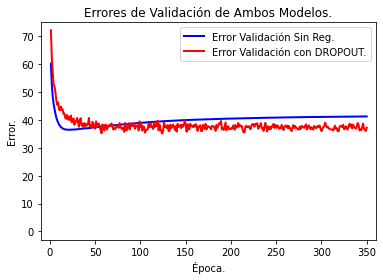

In [38]:
epocas = range(1, len(error_red)+1)
plt.plot(epocas, error_validacion_sdt, color="blue", lw=2, label="Error Validación Sin Reg.")
plt.plot(epocas, error_validacion, color="red", lw=2, label="Error Validación con DROPOUT.")
plt.axis([-10,350+10,-3,75])
plt.title("Errores de Validación de Ambos Modelos.")
plt.xlabel("Época.")
plt.ylabel("Error.")
plt.legend()
plt.show()

Con esta gráfica terminamos por rectificar el "por qué" nuestro modelo con **dropout** se desempeño ligeramente mejor que el modelo sin regularización.

***

### **B**

### <font color="green">Entrenamos dos modelos (uno con regularización DROPOUT y otro sin regularización), sobre las 60,000 muestras que componene al conjunto de entrenamiento de los datos MNIST:</font>

### CON DROPOUT:

In [39]:
np.random.seed(1)
alfa, iteraciones, neuronas_capa_oculta, pixeles_por_imagen, numero_de_clases = (0.005, 350, 40, 784, 10)

pesos_0_1 = 0.2*np.random.random((pixeles_por_imagen, neuronas_capa_oculta)) - 0.1 # Pesos entre capas 0 y 1.
pesos_1_2 = 0.2*np.random.random((neuronas_capa_oculta, numero_de_clases)) - 0.1 # Pesos entre capas 1 y 2.

ps_dt, er_dt, ev_dt = algoritmo_aprendizaje(imagenes_entrenamiento, etiquetas_entrenamiento_ONE_HOT, [pesos_0_1, pesos_1_2], alfa, iteraciones)


Hola ¿Cuál es el error que mínimo que deseas para la red neuronal?:  0
¿Qué tipo de regularización deseas?: Ninguno (0) / Dropout(1) 1
¿Qué porcentaje de DROPOUT deseas? 0 < dp < 1
 0.5



Época: 1
Error Total de la Red sobre los Datos de Entrenamiento: 45.0684436478%
Aciertos sobre Datos de Entrenamiento: 45067.0

Época: 2
Error Total de la Red sobre los Datos de Entrenamiento: 39.2088674645%
Aciertos sobre Datos de Entrenamiento: 48509.0

Época: 3
Error Total de la Red sobre los Datos de Entrenamiento: 38.5811606343%
Aciertos sobre Datos de Entrenamiento: 49164.0

Época: 4
Error Total de la Red sobre los Datos de Entrenamiento: 37.7882090113%
Aciertos sobre Datos de Entrenamiento: 49607.0

Época: 5
Error Total de la Red sobre los Datos de Entrenamiento: 37.5244332132%
Aciertos sobre Datos de Entrenamiento: 49742.0

Época: 6
Error Total de la Red sobre los Datos de Entrenamiento: 37.2854010387%
Aciertos sobre Datos de Entrenamiento: 49862.0

Época: 7
Error Total de la Red sobre los Datos de Entrenamiento: 37.0624034974%
Aciertos sobre Datos de Entrenamiento: 49922.0

Época: 8
Error Total de la Red sobre los Datos de Entrenamiento: 37.0207281247%
Aciertos sobre Datos de

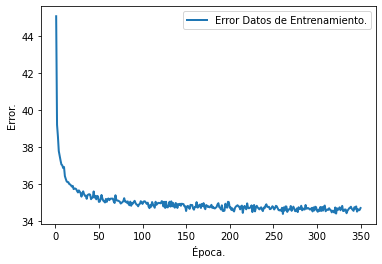

In [40]:
epocas = range(1, len(er_dt)+1)
plt.plot(epocas, er_dt, lw=2, label="Error Datos de Entrenamiento.")
#plt.axis([-10,360,-1,7])
plt.xlabel("Época.")
plt.ylabel("Error.")
plt.legend()
plt.show()

In [41]:
vp_dt = predicciones(ps_dt, imagenes_entrenamiento[:])
print(vp_dt.shape,'\n')

precision_dt = ((etiquetas_entrenamiento[:] == vp_dt).sum()/len(etiquetas_entrenamiento[:]))*100
print(f"La precisión sobre los {imagenes_entrenamiento[:].shape[0]} datos de entrenamiento es del {precision_dt}%")

(60000,) 

La precisión sobre los 60000 datos de entrenamiento es del 94.17%


In [43]:
vp_dt_T = predicciones(ps_dt, imagenes_testeo[:])
print(vp_dt_T.shape,'\n')

precision_dt_T = ((etiquetas_testeo[:] == vp_dt_T).sum()/len(etiquetas_testeo[:]))*100
print(f"La precisión sobre los {imagenes_testeo[:].shape[0]} datos de prueba es del {precision_dt_T}%")

(10000,) 

La precisión sobre los 10000 datos de prueba es del 93.28999999999999%


### SIN DROPOUT:

In [45]:
np.random.seed(1)
alfa, iteraciones, neuronas_capa_oculta, pixeles_por_imagen, numero_de_clases = (0.005, 350, 40, 784, 10)

pesos_0_1 = 0.2*np.random.random((pixeles_por_imagen, neuronas_capa_oculta)) - 0.1 # Pesos entre capas 0 y 1.
pesos_1_2 = 0.2*np.random.random((neuronas_capa_oculta, numero_de_clases)) - 0.1 # Pesos entre capas 1 y 2.

ps_sdt, er_sdt, ev_sdt = algoritmo_aprendizaje(imagenes_entrenamiento, etiquetas_entrenamiento_ONE_HOT, [pesos_0_1, pesos_1_2], alfa, iteraciones)


Hola ¿Cuál es el error que mínimo que deseas para la red neuronal?:  0
¿Qué tipo de regularización deseas?: Ninguno (0) / Dropout(1) 0



Época: 1
Error Total de la Red sobre los Datos de Entrenamiento: 20.8705005652%
Aciertos sobre Datos de Entrenamiento: 54770.0

Época: 2
Error Total de la Red sobre los Datos de Entrenamiento: 14.7003117562%
Aciertos sobre Datos de Entrenamiento: 56751.0

Época: 3
Error Total de la Red sobre los Datos de Entrenamiento: 13.2659675603%
Aciertos sobre Datos de Entrenamiento: 57214.0

Época: 4
Error Total de la Red sobre los Datos de Entrenamiento: 12.4902744585%
Aciertos sobre Datos de Entrenamiento: 57459.0

Época: 5
Error Total de la Red sobre los Datos de Entrenamiento: 12.0054000789%
Aciertos sobre Datos de Entrenamiento: 57633.0

Época: 6
Error Total de la Red sobre los Datos de Entrenamiento: 11.6699623684%
Aciertos sobre Datos de Entrenamiento: 57759.0

Época: 7
Error Total de la Red sobre los Datos de Entrenamiento: 11.4136189812%
Aciertos sobre Datos de Entrenamiento: 57840.0

Época: 8
Error Total de la Red sobre los Datos de Entrenamiento: 11.2083352102%
Aciertos sobre Datos de

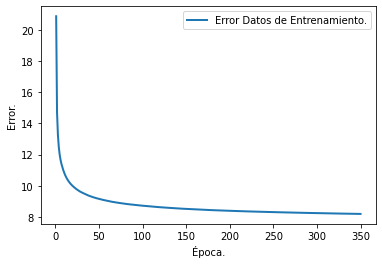

In [48]:
epocas = range(1, len(er_sdt)+1)
plt.plot(epocas, er_sdt, lw=2, label="Error Datos de Entrenamiento.")
#plt.axis([-10,360,-1,7])
plt.xlabel("Época.")
plt.ylabel("Error.")
plt.legend()
plt.show()

In [46]:
vp_sdt = predicciones(ps_sdt, imagenes_entrenamiento[:])
print(vp_sdt.shape,'\n')

precision_sdt = ((etiquetas_entrenamiento[:] == vp_sdt).sum()/len(etiquetas_entrenamiento[:]))*100
print(f"La precisión sobre los {imagenes_entrenamiento[:].shape[0]} datos de entrenamiento es del {precision_sdt}%")

(60000,) 

La precisión sobre los 60000 datos de entrenamiento es del 97.78%


In [47]:
vp_sdt_T = predicciones(ps_sdt, imagenes_testeo[:])
print(vp_sdt_T.shape,'\n')

precision_sdt_T = ((etiquetas_testeo[:] == vp_sdt_T).sum()/len(etiquetas_testeo[:]))*100
print(f"La precisión sobre los {imagenes_testeo[:].shape[0]} datos de prueba es del {precision_sdt_T}%")

(10000,) 

La precisión sobre los 10000 datos de prueba es del 95.66%


**Observaciones:**  

Cuando realizamos inferencia sobre los datos de entrenamiento, observamos que el primer modelo (modelo con **dropout**), tiene una precisión menor que el segundo (modelo sin ningun tipo de regularización). Además, al analizar la precisición de ambos modelos sobre los datos de testeo, notamos una mayor precisión en el segundo modelo. Es decir, (teniendo en mente que el desempeño sobre los datos de testeo es el verdaderamente importante), el segundo modelo es una mejor opción debido a que contamos con una gran cantidad de datos para entrenar nuestro modelo.

***

**CONCLUSIÓN GENERAL:**

<font color="red">Una buena técnica para evitar que nuestra red memorice en lugar de generalizar cuando se cuenta con una pequeña cantidad de datos, es aplicar algún tipo de regularización. Asimismo, de manera empírica y desde mi punto de vista, cuando se cuenta con una enorme variedad de datos (y dependiendo de la arquitectura), la regularización puede no ser necesaria e inclusive podría perjudicar en un pequeño porcentaje a la precisión sobre los datos nunca antes vistos, esto se aprecia se aprecia en el inciso **B**. Sin embargo, *en la práctica se puede experimentar con un modelo complejo aplicando algún tipo de regularización y con un modelo sin regularización para observar cual nos otorga mejores resultados.*</font>